# Example Notebook for Keysight  Infiniium Oscilloscopes
This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight Infinium Oscilloscopes. The driver has been tested with the MSOS104A.
Please note that the oscilloscopes have plenty of more functions, that have not yet been implemented. Feel free to contribute, request features or report bugs.

In [1]:
%matplotlib inline

### Importing Dependencies

In [3]:
# python imports
import logging
# third party
import matplotlib.pyplot as plt

# qcodes imports
import qcodes.instrument_drivers.Keysight.Infiniium as MSO

#setup
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

### Create the Instrument
please insert the right address of your local scope (TCPIP...) you can find the address with the NI-MAX app or within the network settings of the scope.

In [5]:
mso = MSO.Infiniium('MSO', 'TCPIP0::A-PCSERNO-47466::inst0::INSTR')

Connected to: KEYSIGHT TECHNOLOGIES MSOS104A (serial:MY55510104, firmware:06.00.00901) in 0.06s


### Prepare Trace
In this example we are going to acquire the a 100kHz sine wave with 1Vpp from a waveform generator at connected to channel 4 of the scope. Therefore:
 - all the other channels are hidden
 - the time scale is adjusted to allow for one periode
 - the time scale is adjusted to have times starting from zero
 - the range of channel four is set to 1.2V

In [6]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch4.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(5e-3)
mso.ch4.range(1.2)

### Trigger Setup
we want to use the input signal itself as the trigger. Therefor the trigger is first enabled, the trigger source is set and we raise the level to 0.4 V, just for avoiding a boring symmetric function.

In [7]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel4')
mso.trigger_edge_slope('negative')
mso.ch4.trigger_level(0.4)

## Data Acquisition
We are going to acquire 100k datapoints with 16bit depth over one periode. So we need a sample rate of 10 MS/s.

In [8]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

It is important to remember to prepare the trace before acquisition.

In [9]:
mso.ch4.trace.prepare_curvedata()

Then the parameter can be acquire as usual

In [10]:
t=mso.ch4.trace.get()

The data looks as expected (hopefully)

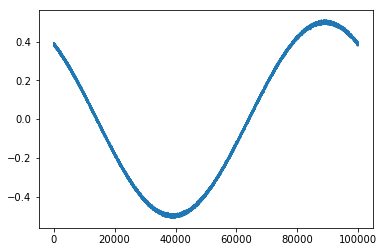

In [11]:
p = plt.plot(t)

We can aquire another sample

In [12]:
t2=mso.ch4.trace.get()

and look at the noise:

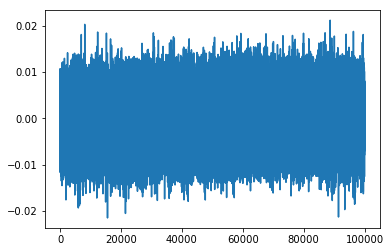

In [13]:
p2 = plt.plot(t-t2)